### 신경 스타일 전이 (Neural Style Transfer)
- 신경 스타일 전이란 어떤 것이던 2개의 이미지가 존재한다면 한 이미지에서는 스타일을, 다른 이미지에서는 내용을 가져와 두 이미지의 스타일과 내용이 합성된 제 2의 이미지를 만들어 내는 것이다.
- 먼저 Convolution Layer을 이용해서 한 장의 이미지를 재생성하는 텍스처 합성에 대해 구현을 해 본 뒤에 2장의 이미지에서 각각 스타일과 내용을 가져와 합성하는 신경 스타일 전이를 구현해 보고자 한다.

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### 텍스쳐 합성(Texture Synthesis)
- 한장의 이미지를 원본으로 삼아 해당 텍스트를 재생성(합성) 하는 작업이다.
- 오토인코더처럼 이미지를 완전히 재생성하는 것이 아니기 때문에 합성되는 이미지는 원본과 비슷해야 하지만 똑같으면 안되고 어색한 부분과 반복되는 부분이 없이 원하는 크기로 재생성이 가능해야 한다.  

- 기존의 텍스트 합성 방법 중에서 가장 효과적이었던 방법은
  1. 픽셀이나 이미지를 잘게 쪼갠 단위인 Patch를 재배열
  2. Parameter에 의한 텍스쳐 합성
    - 원본 텍스처의 공간적인 통곗값을 사람이 정교하게 만든 여러개의 필터로 구한다 (이 통곗값을 parameter이라고 함)
    - 필터를 통과한 결과물이 같다면 같은 텍스쳐라고 가정하고 결과물이 같아질 때 까지 target texture을 변형 시킨다.
      - 여기에서, 즉 **필터** 대신에 **Convolution Layer**을 이용하고자 한다.


#### 텍스쳐 합성을 위해 특징 추출기로 이번에 이용할 모델은 VGG-19이다.
- 신경망의 각 뉴런마다 주목하는 이미지의 특징이 다를텐데, 이러한 특징 추출값을 종합해면 이미지의 공간적 통곗값을 뽑아 내는 것이 가능하다.
- 이렇게 뽑아내기 위해서는 각 layer의 특징 추출값에서 Gram matrix라는 값을 계산해야 한다.
  - Gram matrix란 앞에서 본 뉴런의 특징 추출값을 1차원의 벡터로 바꾼 뒤에 벡터를 쌓아 올린 행렬을 transpose행렬과 행렬곱을 실행해서 얻는 값이다.
  - 이는 특징 추출값의 자기 자신에 대한 점곱과 같다.
- 이렇게 target texture과 real texture의 gram matrix값을 모두 구한 뒤에 구 gram matrix의 평균 제곱 오차(mse)를 구해야 한다.
- 그리고 이 오차가 작아지도록 target texture를 변형하면 원본 텍스쳐를 닮은 target texture를 생성할 수 있다.  

In [3]:
style_path = tf.keras.utils.get_file('style.jpg','http://bit.ly/2mGfZIq')

344064/337723 [==============================] - 0s 0us/step


In [4]:
style_path

'/root/.keras/datasets/style.jpg'

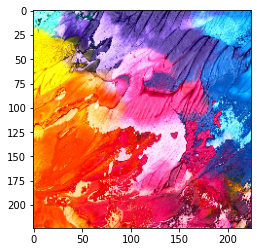

In [8]:
import cv2
style_image = plt.imread(style_path)
style_image = cv2.resize(style_image, dsize = (224,224))
style_image = style_image/255.0
plt.imshow(style_image)


- 현재 다운 받은 이미지는 원본 이미지이고 우리는 이제 target texture을 구해 주어야 한다.
- target texture은 random noise image에서 시작할텐데, 이는 0에서 1 사이의 랜덤한 값을 구하고 각 픽셀에 RGB값을 넣어주면 완성이다.

In [68]:
import random
target_noise = tf.random.uniform(style_image.shape, 0,1)

In [12]:
target_noise.shape

TensorShape([224, 224, 3])

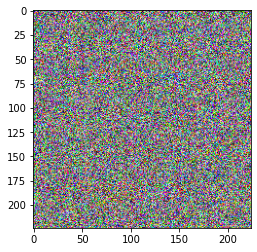

In [13]:
plt.imshow(target_noise)

- 이제 random하게 불러온 target image까지 만들었으니 스타일 특징 출력기로 사용할 모델을 불러와야 한다.

In [38]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

vgg = VGG19(include_top = False, weights = 'imagenet')
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

- 당연히 우리는 모델로부터 convolution층과 pooling층을 이용하여 이미지의 특징을 추출해 내는 것이 목표이기 때문에 모델의 Dense layer을 제외하고 이용해 주면 된다.

In [78]:
dense_layer = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

vgg.trainable = False
outputs = [vgg.get_layer(layer).output for layer in dense_layer]
model = tf.keras.Model([vgg.input], outputs)


In [79]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)  

In [19]:
def gram_matrix(trait):
  channel = int(trait.shape[-1])
  #먼저 추출된 특징 값을 벡터의 형태로 변환시킨다.
  trait = tf.reshape(trait, [-1, channel])
  n = tf.shape(trait)[0]
  #이후 이 각 벡터의 값마다 자기 자신과 곱한 뒤에 (tf.matmul()) 
  gram = tf.matmul(trait, trait, transpose_a = True)
  #특징들의 평균값을 구하는 것이기 때문에 n, 즉 전체 1차원으로 변환된 벡터의 길이로 나눈다.
  return gram / tf.cast(n, tf.float32)


In [22]:
style_image = plt.imread(style_path)
style_image = cv2.resize(style_image, (224,224))
style_image = style_image / 255.0

style_batch = style_image.astype('float32')
style_batch = tf.expand_dims(style_batch, axis = 0)
style_output = model(preprocess_input(style_batch*255.0))


- preprocess_input()함수는 0-255.0의 픽셀값을 가진 이미지가 들어오는 것을 전제로 만들어진 함수이기 때문에 255.0으로 나누어서 픽셀 정규화를 해준 이미지 데이터에 다시 255.0을 곱해서 입력을 한다.
- style_output는 다섯 layer를 통과한 특징 추출값으로 구성이 되어있다.

In [28]:
style_output[0].numpy().shape

(1, 224, 224, 64)

- 앞에 batch_size가 shape에 그대로 있어서 차원이 4D이다. 따라서 tf.squeeze()함수를 이용해서 차원을 바꾸어준다 (axis = 0 으로 두면 batch_size열의 차원을 줄여준다.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


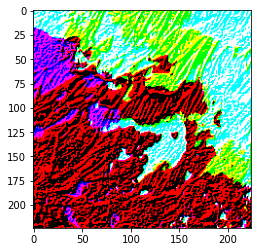

In [32]:
plt.imshow(tf.squeeze(style_output[0][:,:,:,:3], axis = 0))

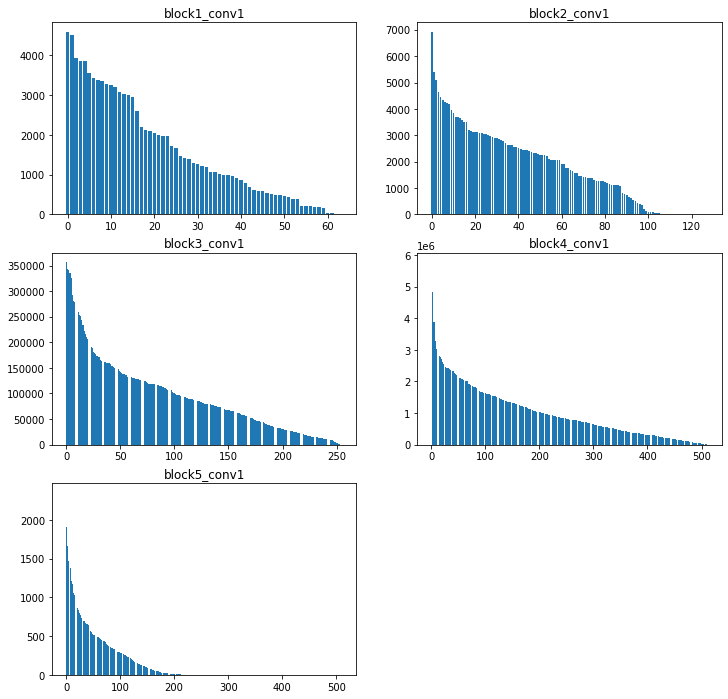

In [37]:
style_outputs = [gram_matrix(i) for i in style_output]

plt.figure(figsize = (12,12))
for i in range(5):
  plt.subplot(3,2,i+1)
  array = sorted(style_outputs[i].numpy()[0].tolist())
  array = array[::-1]
  plt.bar(range(style_outputs[i].shape[0]), array)
  plt.title(dense_layer[i])
plt.show()

- 위의 시각화한 결과에 의하면 gram matrix의 값은 layer마다 제각기 다르게 나오고 최댓값도 차이가 너무 많이 난다.
- 물론 각 layer에서 구한 gram_matrix값에 가중치를 곱해 주어서 특정 layer가 영향을 너무 크게 미치지 못하도록 할 수 있을 것이다.

- target texture를 update해주기 위해서는 
  1. target texture에서 gram matrix값을 구해주는 함수
  2. 원본 texture의 gram matrix와 target의 gram matrix사이의 sgd값을 구해주는 함수
  3. 출력되는 픽셀의 값의 범위가 0.0에서 1.0사이를 유지하도롣 제한하는 함수  
를 만들어 주어야 한다.  

In [70]:
def get_outputs(image):
  image_batch = tf.expand_dims(image, axis = 0)
  trait = model(preprocess_input(image_batch * 255.0))
  outputs = [gram_matrix(i) for i in trait]
  return outputs


In [71]:
def get_loss(real, target):
  return tf.reduce_sum([tf.reduce_mean((r-t)**2) for r,t in zip(real, target)])

In [72]:
def fix_img(image):
  return tf.clip_by_value(image, clip_value_min = 0.0, clip_value_max = 1.0)

- 이제는 이미지를 업데이트 하는 부분에 대한 함수의 정의를 해야 한다.
- 우리는 학습해야 할 가중치가 존재하는 것이 아니라 2개의 이미지와 그 이미지의 특징 벡터의 gram_matrix값의 sgd loss의 값만 알고 있다.
  - 따라서 tensorflow의 Gradient Tape를 이용해 주어야 한다.
  - 이는 어떠한 식이 들어가도 자동 미분을 해서 입력에 대한 손실을 구한 뒤에 다른 변수에 대한 기울기를 구한다.

In [73]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.2, beta_1 = 0.99, epsilon = 1e-1)

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = get_outputs(image)
    loss = get_loss(style_outputs, outputs)
  
  gradient = tape.gradient(loss, image)
  adam.apply_gradients([(gradient, image)])
  image.assign(fix_img(image))


- 위의 코드중에 @tf.function()은 장식자 라는 것으로, 함수나 클래스 앞에 붙어서 이용이 된다.
- 그리고 함수속의 코드에 대해 간단하게 설명을 해 보자면 랜덤한 이미지 형태의 noise를 입력 받아 이를 model이 입력 받아 출력한 특징 벡터에 대한 gram matrix값을 계산해서 이를 이용해 원본 데이터와의 오차를 계산한다.
- 그리고 입력 받은 것에 따라 손실의 미분 값을 구하고 그 미분 값들을 갱신을 위해서 optimizer에 넣어준다. 
  - 이렇게 넣어 주면 입력값인 image가 입력값에 의해서 변화한다.

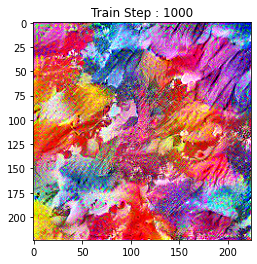

In [74]:
import IPython.display as display
import time
import imageio

start = time.time()

image = tf.Variable(target_noise)

epoch, steps_per_epoch = 10, 100

step = 0
for i in range(epoch):
  for j in range(steps_per_epoch):
    step += 1
    train_step(image)
  if i%5 == 0 or i == epoch -1:
    imageio.imwrite('style_spoch{0}.png'.format(i), image.read_value().numpy())    
  display.clear_output(wait = True)
  plt.imshow(image.read_value())
  plt.title('Train Step : {}'.format(step))
  plt.show()

end = time.time()

**중간에 학습을 멈춰서(시간이 너무 오래 걸려서) KeyboardInterrupt가 발생했다.**

- target texture에 tf.Variable을 씌워서 image라는 변수로 저장해야 한다. 
- tensorflow 에서 그래프 연산을 하는 tensor는 tf.Variable, tf.constant에 저장해서 이용해야 한다.
  - 원래는 이 작업을  tf.keras 에 적용하면 알아서 진행하겠지만 이 경우에는 변환을 직접 해 주어야 한다.

- 그러나 이미지에 생기는, 표면이 자글자글한 점을 개선하기 위해서는 variation loss라는 작업을 진행해 주면 좋다.
  - 이는 이미지에 생기는 noise를 개선해 주기 위한 것으로, 어떤 픽셀과 그 옆에 인접한 픽셀의 차이를 의미한다.
  - 이 variation loss가 작을 수록 이미지는 더욱 더 매끄럽게 보이게 될 것이다.

In [54]:
def vari_x_y(image):
  #image의 shape가 (224,224,3)임을 고려해서 아래와 같이 구현을 했다.
  x_var = image[:,1:, :]-image[:, :-1, :]
  y_var = image[1:,:,:] - image[:-1,:,:]
  return x_var, y_var

def total_var_loss(image):
  x,y = vari_x_y(image)
  return tf.reduce_mean(x**2) + tf.reduce_mean(y**2)

In [64]:
total_var_weight = 1e9
style_weight = 1e-1

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    style = get_outputs(image)
    loss = style_weight * get_loss(style_outputs, style)
    loss += total_var_weight * total_var_loss(image)
    
  gradient = tape.gradient(loss, image)
  adam.apply_gradients([(gradient, image)])
  image.assign(fix_img(image))


- 훈련 실행과 이미지의 출력은 위와 동일하게 진행해 준다. (다만 시간이 너무 오래 걸릴 것 같아서 epoch횟수는 10으로 줄였다.-> 현재 이미지의 noise가 줄었는지만 확인하면 되기 때문)

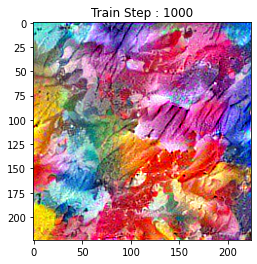

In [65]:
start = time.time()

image = tf.Variable(target_noise)

epoch, steps_per_epoch = 10, 100

step = 0
for i in range(epoch):
  for j in range(steps_per_epoch):
    step += 1
    train_step(image)
  if i%5 == 0 or i == epoch -1:
    imageio.imwrite('style_spoch{0}.png'.format(i), image.read_value().numpy())    
  display.clear_output(wait = True)
  plt.imshow(image.read_value())
  plt.title('Train Step : {}'.format(step))
  plt.show()

end = time.time()

In [66]:
print('noise : {}'.format(total_var_loss(tf.Variable(target_noise))))
print('real : {}'.format(total_var_loss(style_image)))
print('made : {}'.format(total_var_loss(image.read_value())))

noise : 0.3322794735431671
real : 0.03641251305469578
made : 0.03243643045425415


- 결과를 보면 순서대로 random noise, real_image, target_image의 variation loss를 구했는데, 확실히 나아졌음을 알 수 있고 원본 이미지보다도 적어졌음을 알 수 있다.
  - 아마 epoch의 횟수를 늘렸다면 원본 이미지보다 loss가 훨씬 적었을 수도 있겠다는 생각이 든다.

### 신경 스타일 전이
- 위에서는 텍스쳐의 전이만 진행했다면 이번에는 새로운 특징인 content전이도 해볼 예정이다.
- 즉, target texture을 만들기 위해 style texture과 gram matrix(추출한 특징들의 평균값)의 MSE값을 구하고, content texture과는 픽셀값의 차이인 MSE를 구한다.
- 그런데 content texture를 구하기 위해서는 style texture에서는 5개의 layer모두에서 특징 추출을 얻은 것과는 달리 마지막 layer에서만 특징 추출값을 얻게 된다. 
  - 이는 앞쪽 layer의 데이터를 이용하면 원본 이미지의 픽셀 자체를 가져오게 되는 결과를 초래 할 수 있는데, 신경 스타일 전이의 목적은 완전한 모사가 아닌 구도를 복사하는 것이기 때문에 뒤쪽 layer의 값을 이용한다.

761856/754420 [==============================] - 0s 0us/step


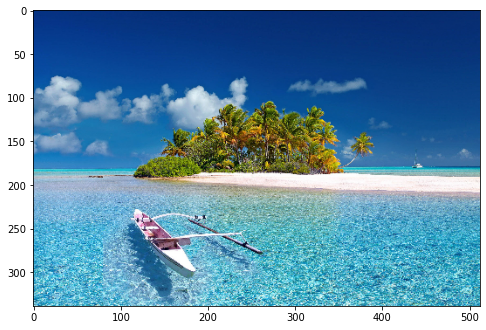

In [75]:
content_path = tf.keras.utils.get_file('content.jpg', 'http://bit.ly/2mAfUX1')

content_image = plt.imread(content_path)

max_dim = 512

long_dim = max(content_image.shape[:-1])
scale = max_dim / long_dim
new_height = int(content_image.shape[0]*scale)
new_width = int(content_image.shape[1]*scale)

content_image = cv2.resize(content_image, (new_width, new_height))
content_image = content_image/255.0
plt.figure(figsize = (8,8))
plt.imshow(content_image)




- 이미지의 가로와 세로중 긴 축을 512 픽셀에 맞추어서 resize헀다.
- 이때에 주의할 점은 content texture과 target texture이 크기가 같아야 한다는 점이다.
   - style texture의 경우에는 픽셀의 개수를 기준으로 계산이 되기 때문에 상관이 없지만 content texture의 경우에는 특징 추출값의 픽셀을 MSE를 이용해서 비교하기 때문에 반드시 크기가 같아야 한다.

In [80]:
content_batch = content_image.astype('float32')
content_batch = tf.expand_dims(content_batch, axis = 0)

content_layers = ["block5_conv2"]

vgg.trainable = False
outputs = [vgg.get_layer(name).output for name in content_layers]
model_content = tf.keras.Model([vgg.input], outputs)
content_output = model_content(preprocess_input(content_batch*255.0))

In [82]:
model_content.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)  

- content 특징의 추출을 위해서 style을 추출하는 별도의 모델을 만들어서 model_content에 저장하고, 이 모델을 사용해서 content texture에서 미리 특징을 추출해서 content_output변수에 저장을 한다.

In [86]:
def get_content_output(image):
  image_batch = tf.expand_dims(image, axis = 0)
  output = model_content(preprocess_input(image_batch*255.0))
  return output

def get_content_loss(image, content_output):
  return tf.reduce_sum(tf.reduce_mean((image-content_output)**2))

In [87]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1 = 0.99, epsilon = 1e-1)

total_var_weight = 1e9
style_weight = 1e-2
content_weight = 1e4

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = get_outputs(image)
    output2 = get_content_output(image)
    loss = style_weight * get_loss(outputs, style_outputs)
    loss += content_weight*get_content_loss(output2, content_output)
    loss += total_var_loss(image)*total_var_weight

  gradient = tape.gradient(loss, image)
  adam.apply_gradients([(gradient, image)])
  image.assign(fix_img(image))


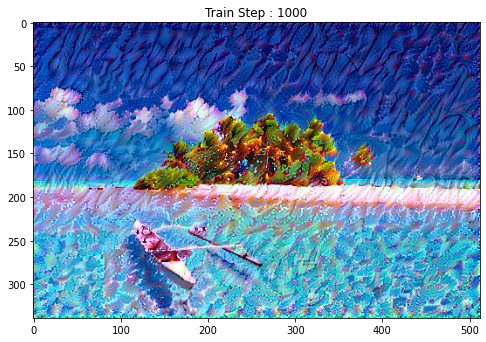

In [88]:
image = tf.Variable(content_image.astype('float32'))

epoch = 10
steps_per_epoch = 100

step = 0
for i in range(epoch):
  for j in range(steps_per_epoch):
    step += 1
    train_step(image)
  display.clear_output(wait = True)
  plt.figure(figsize = (8,8))
  plt.imshow(image.read_value())
  plt.title('Train Step : {}'.format(step))
  plt.show()